# Dinamic Journeys

In [1]:
import pathlib

import jupedsim as jps
import matplotlib.pyplot as plt
import pedpy
from shapely import GeometryCollection, Polygon
from shapely import unary_union
import random
from typing import Tuple
import pandas as pd
import numpy as np
import numpy.typing as npt
from scipy import stats
from plotly.subplots import make_subplots
import math
import plotly.graph_objects as go

%matplotlib inline

from jupedsim.internal.notebook_utils import animate, read_sqlite_file

In [2]:
area = Polygon([[0,0],[40,0], [40, -5], [45,-5], [45,0], [70,0], [70,5], [55,5], [55,10], [50,10], [50,5], [0, 5]])
exits = [
    Polygon([[0,0],[5,0],[5,5],[0,5]]),
    Polygon([[65,0], [70,0], [70,5], [65, 5]])
]

starting_point = Polygon([[40,-5], [45,-5], [45,0], [40,0]])

problem_area = Polygon([[50,5], [55,5], [55,10], [50,10]])

walkable_area = pedpy.WalkableArea(area)

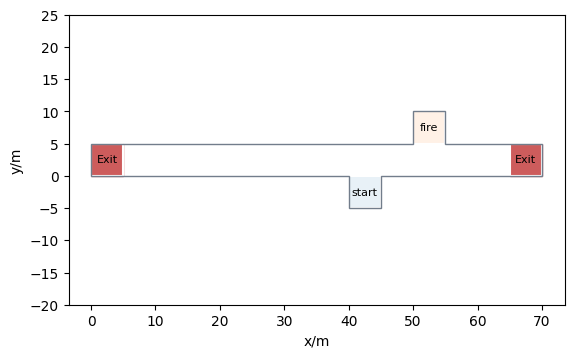

In [3]:
# Configurar el gráfico
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_aspect("equal")

# Ajustar límites basados en el área transitable
_, ymin, _, ymax = walkable_area.bounds
ax.set_ylim(ymin - 15, ymax + 15)

# Dibujar el área transitable
pedpy.plot_walkable_area(walkable_area=walkable_area, axes=ax)

# Dibujar las áreas individuales con etiquetas
x, y = starting_point.exterior.xy
plt.fill(x, y, alpha=0.1)  # Relleno de las áreas
plt.plot(x, y, color="white")  # Bordes de las áreas
centroid = starting_point.centroid  # Centroid del área
plt.text(centroid.x, centroid.y, "start", ha="center", va="center", fontsize=8)  # Etiqueta

x, y = problem_area.exterior.xy
plt.fill(x, y, alpha=0.1)  # Relleno de las áreas
plt.plot(x, y, color="white")  # Bordes de las áreas
centroid = problem_area.centroid  # Centroid del área
plt.text(centroid.x, centroid.y, "fire", ha="center", va="center", fontsize=8)  # Etiqueta

for exit in exits:
    x, y = exit.exterior.xy
    plt.fill(x, y, color="indianred")  # Relleno de las áreas
    plt.plot(x, y, color="white")  # Bordes de las áreas
    centroid = exit.centroid  # Centroid del área
    plt.text(centroid.x, centroid.y, "Exit", ha="center", va="center", fontsize=8)  # Etiqueta
# Mostrar el gráfico
plt.show()

In [4]:
simulations = {}
simulation_names = ["no_obstacle"]
trajectory_files = dict()
for name in simulation_names:
    trajectory_files[name] = f"../../sqlite_data/dinamic_journeys_{name}.sqlite"
    simulation = jps.Simulation(
        dt=0.01,
        model=jps.CollisionFreeSpeedModel(),
        geometry=walkable_area.polygon,
        trajectory_writer=jps.SqliteTrajectoryWriter(
            output_file=pathlib.Path(trajectory_files[name])
        ),
    )

    simulations[name] = simulation

In [5]:
total_agents = 20
agents = jps.distribute_by_number(
    polygon=starting_point,
    number_of_agents=total_agents,
    distance_to_agents=0.4,
    distance_to_polygon=0.6,
    seed=45131502,
)
agents_id = dict()
journeys_id = dict()
exits_id = dict()
for name, simulation in simulations.items():

    exits_id[name] = [
        simulation.add_exit_stage(exits[1]),
        simulation.add_exit_stage(exits[0])
    ]


    journeys_id[name] = [
        simulation.add_journey(jps.JourneyDescription([exit_])) for exit_ in exits_id[name]
    ]
    agents_id[name] = []
    for agent in agents:
        agents_id[name].append(
            simulation.add_agent(
                jps.CollisionFreeSpeedModelAgentParameters(
                    position=agent,
                    journey_id=journeys_id[name][0],
                    stage_id= exits_id[name][0],
                )
            )
        )

In [6]:
for name, simulation in simulations.items():
    while simulation.agent_count() > 0:

        simulation.iterate()
        if simulation.iteration_count() > 2000:
            #stage = simulation.get_stage(exits_simulation_list[0])
            #if isinstance(stage, jps.ExitStage):
            for agent in simulation.agents():
                simulation.switch_agent_journey(
                    agent.id,
                    journeys_id[name][1],
                    exits_id[name][1]
                )


In [125]:
for name , trajectory_file in trajectory_files.items():
    trajectory_data, walkable_area = read_sqlite_file(trajectory_file)
    animate(trajectory_data, walkable_area, title_note=f"{name}").show()